In [1]:
import os, sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import pixelator
from pixelator import read

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [5]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from pixelator import read, simple_aggregate
import seaborn as sns

In [6]:
import plotly.graph_objects as go
import plotly.io as pio

# Pixelgen data analysis

In [7]:
from pathlib import Path

DATA_DIR = Path.cwd().parents[0] / "data" / 'pixelgen' / 'raw'
data_files = [
    DATA_DIR / "Sample03_Raji_control.dataset.pxl",
    DATA_DIR / "Sample04_Raji_Rituximab_treated.dataset.pxl",
]
data_files = [
    DATA_DIR / "Uropod_control.dataset.pxl",
    DATA_DIR / "Uropod_CD54_fixed_RANTES_stimulated.dataset.pxl",
]

In [8]:
pg_data_combined = simple_aggregate(
    ["Control", "Stimulated"], [read(path) for path in data_files]
)

components_to_keep = pg_data_combined.adata[
    (pg_data_combined.adata.obs["edges"] >= 8000)
    & (pg_data_combined.adata.obs["tau_type"] == "normal")
].obs.index

pg_data_combined = pg_data_combined.filter(
    components=components_to_keep
)

polarity_scores = pg_data_combined.polarization
colocalization_scores = pg_data_combined.colocalization
edgelist = pg_data_combined.edgelist

In [9]:
pg_data_combined.adata.obs['sample'].value_counts()

Control       457
Stimulated    328
Name: sample, dtype: int64

In [10]:
for row in pg_data_combined.adata.obs.itertuples():
    # Get component name
    component = row.Index

    graph = pg_data_combined.graph(component,
                                add_node_marker_counts=True,
                                simplify=True,
                                use_full_bipartite=True)
    graph_layout_data = graph.layout_coordinates("fruchterman_reingold_3d",
                                                only_keep_a_pixels=True,
                                                get_node_marker_matrix=True, )
    break

In [11]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x"],
            y=graph_layout_data["y"],
            z=graph_layout_data["z"],
            mode="markers",
            marker=dict(size=3, opacity=0.4, colorscale="bluered"),
            marker_color=graph_layout_data["CD50"],
        ),
    ]
)
fig.update_layout(title=component)
fig.show()

In [12]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x_norm"],
            y=graph_layout_data["y_norm"],
            z=graph_layout_data["z_norm"],
            mode="markers",
            marker=dict(size=3, opacity=0.4, colorscale="bluered"),
            marker_color=graph_layout_data["CD50"],
        ),
    ]
)
fig.update_layout(title=component)
fig.show()

# Test spherique delaunay triangulization

In [13]:
from py_sphere import voronoi_utility

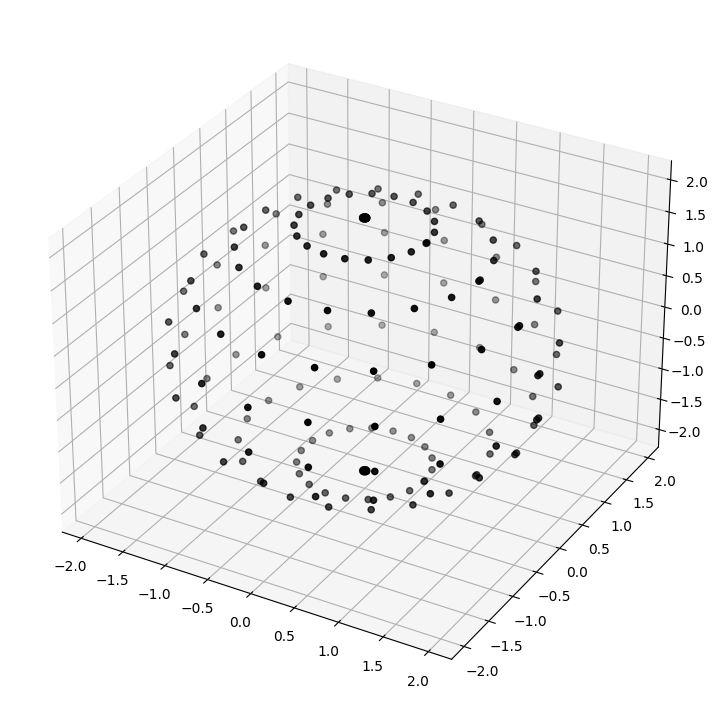

In [14]:
#for testing, produce a mesh of points on a sphere:
circumdiameter = 4.0
u, v = np.mgrid[0.01:2*np.pi-0.01:20j, 0.01:np.pi-0.01:10j]
x=circumdiameter/2.0 * (np.cos(u)*np.sin(v))
y=circumdiameter/2.0 * (np.sin(u)*np.sin(v))
z=circumdiameter/2.0 * (np.cos(v))
#and plot the points to confirm spherical shape by visual inspection:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
#ax1.plot_wireframe(x, y, z, color='r',alpha=0.5)
ax1.scatter(x.ravel(),y.ravel(),z.ravel(),c='k')
fig.set_size_inches(9.0,9.0)

In [15]:
#now, let's see if the Delaunay Triangulation from my code looks sensible or even works at all:
input_sphere_coordinate_array = np.zeros((200,3))
input_sphere_coordinate_array[...,0] = x.ravel()
input_sphere_coordinate_array[...,1] = y.ravel()
input_sphere_coordinate_array[...,2] = z.ravel()
voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(input_sphere_coordinate_array)

In [16]:
Delaunay_point_array = voronoi_instance.delaunay_triangulation_spherical_surface()
Delaunay_point_array.shape,x.ravel().shape



((396, 3, 3), (200,))

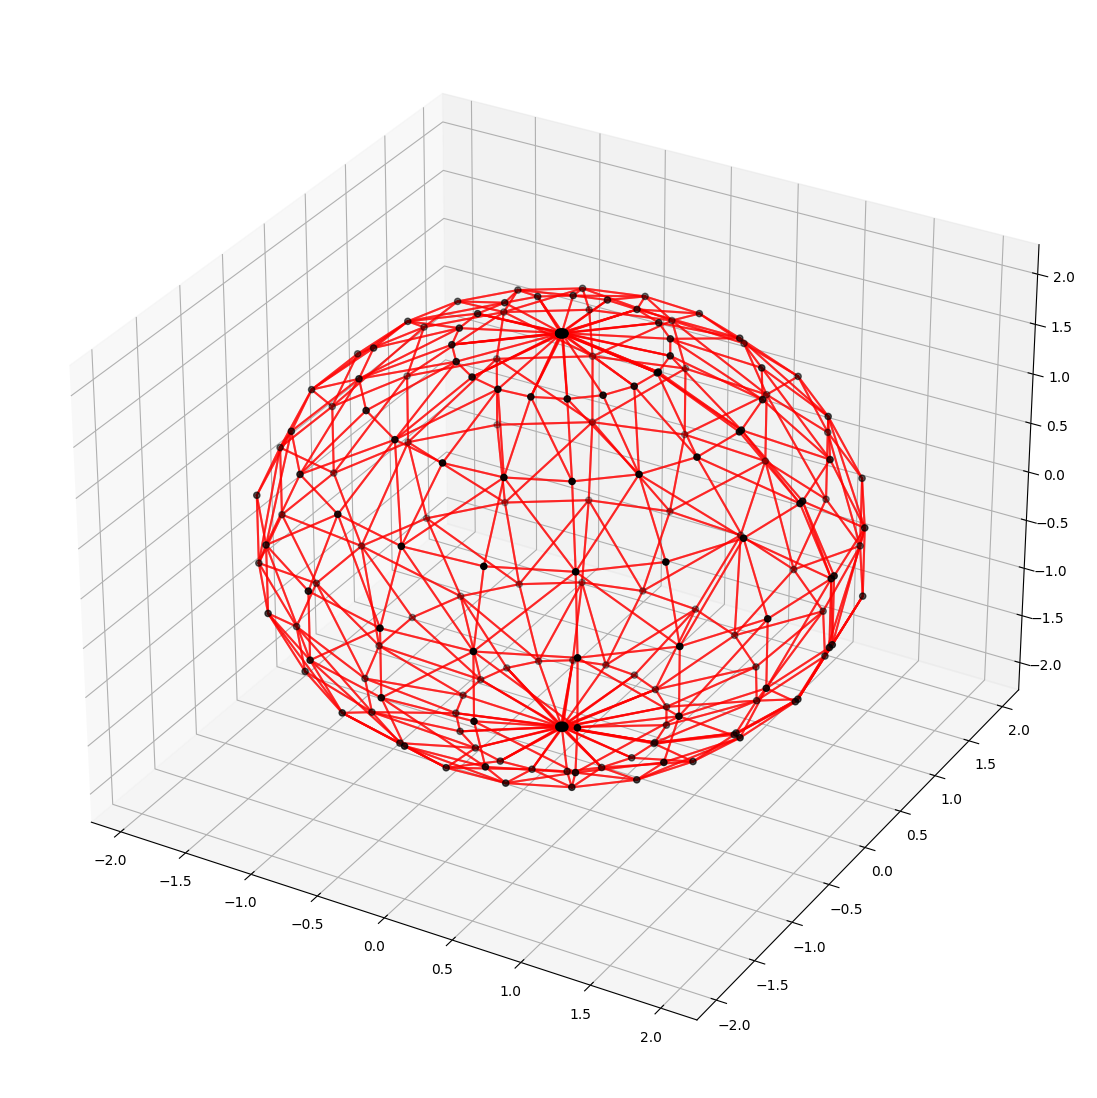

In [17]:
#try to plot the triangles of the Delaunay tesselation to see if they look reasonable by visual inspection relative to the data points:
fig2 = plt.figure()
fig2.set_size_inches(14,14)
ax = fig2.add_subplot(111, projection='3d')
for triangle_coordinate_array in Delaunay_point_array:
    #plot the Delaunay edges in red--using separate calls to close the triangles
    ax.plot(triangle_coordinate_array[...,0],triangle_coordinate_array[...,1],triangle_coordinate_array[...,2],c='r',alpha=0.6)
    connecting_array = np.delete(triangle_coordinate_array,1,0)
    ax.plot(connecting_array[...,0],connecting_array[...,1],connecting_array[...,2],c='r',alpha=0.6)
ax.scatter(x.ravel(),y.ravel(),z.ravel(),c='k') #the original data points in black
    

In [18]:
#generate a random distribution of points on the unit sphere (http://mathworld.wolfram.com/SpherePointPicking.html)
import numpy.random
import math

#go for 1000 random points
u = numpy.random.random((200,)) #200 points on interval [0,1); ideally want (0,1), but perhaps close enough?
v = numpy.random.random((200,))
theta_array = 2 * math.pi * u
phi_array = numpy.arccos((2*v - 1.0))
r_array = numpy.ones((200,))
spherical_polar_coord_array = numpy.column_stack((r_array,theta_array,phi_array))
#convert to Cartesian coordinates
cartesian_coord_array = voronoi_utility.convert_spherical_array_to_cartesian_array(spherical_polar_coord_array)

(-1.0, 1.0)

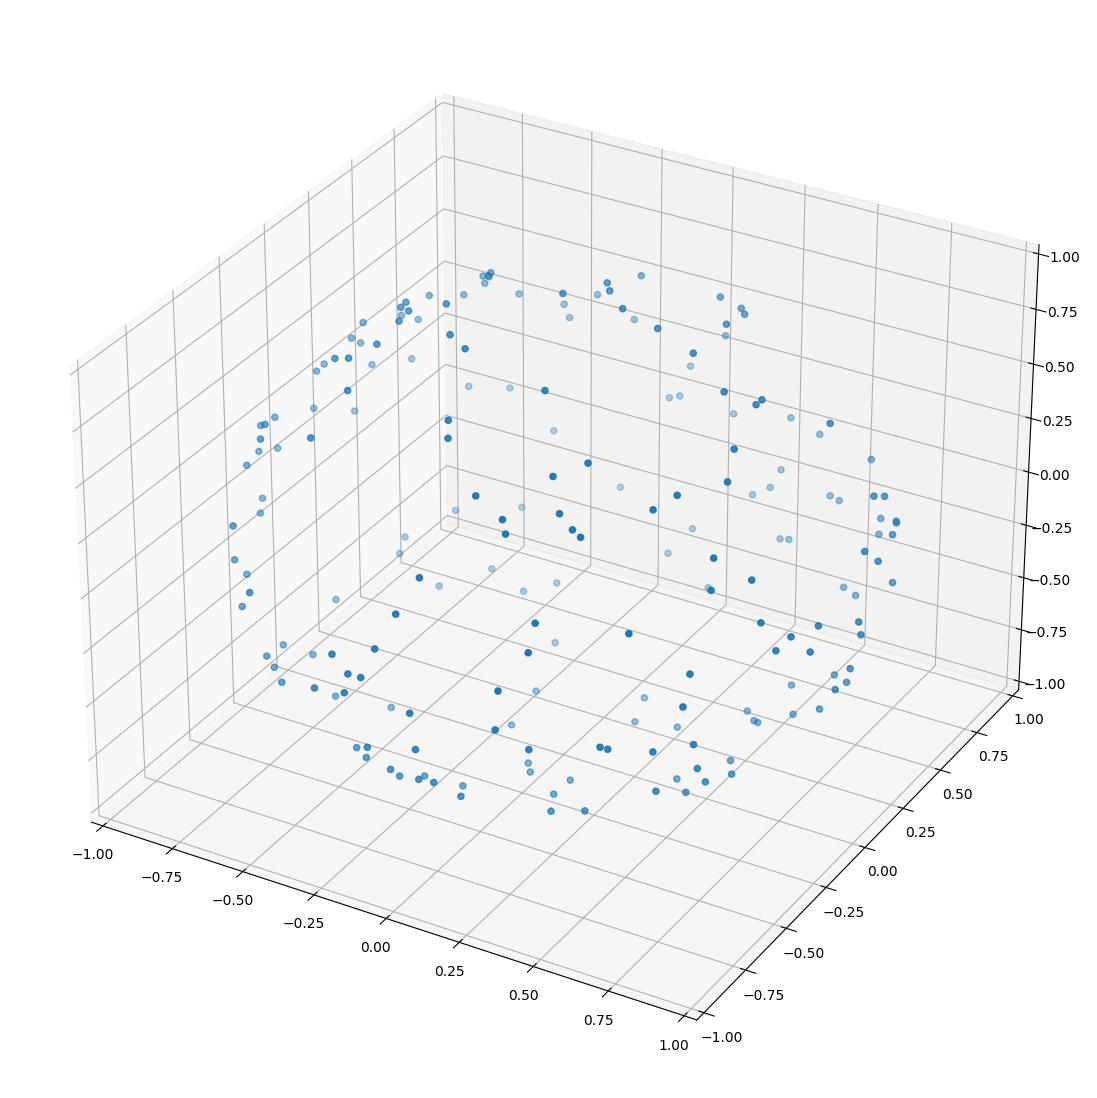

In [19]:
#test plot the random points on unit sphere
fig4 = plt.figure()
fig4.set_size_inches(14,14)
ax = fig4.add_subplot(111, projection='3d')
ax.scatter(cartesian_coord_array[...,0],cartesian_coord_array[...,1],cartesian_coord_array[...,2])
ax.set_ylim(-1,1)     
ax.set_xlim(-1,1)     
ax.set_zlim(-1,1)     

In [20]:
voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(cartesian_coord_array)


In [21]:
Delaunay_point_array = voronoi_instance.delaunay_triangulation_spherical_surface()
Delaunay_point_array.shape, x.ravel().shape


((396, 3, 3), (200,))

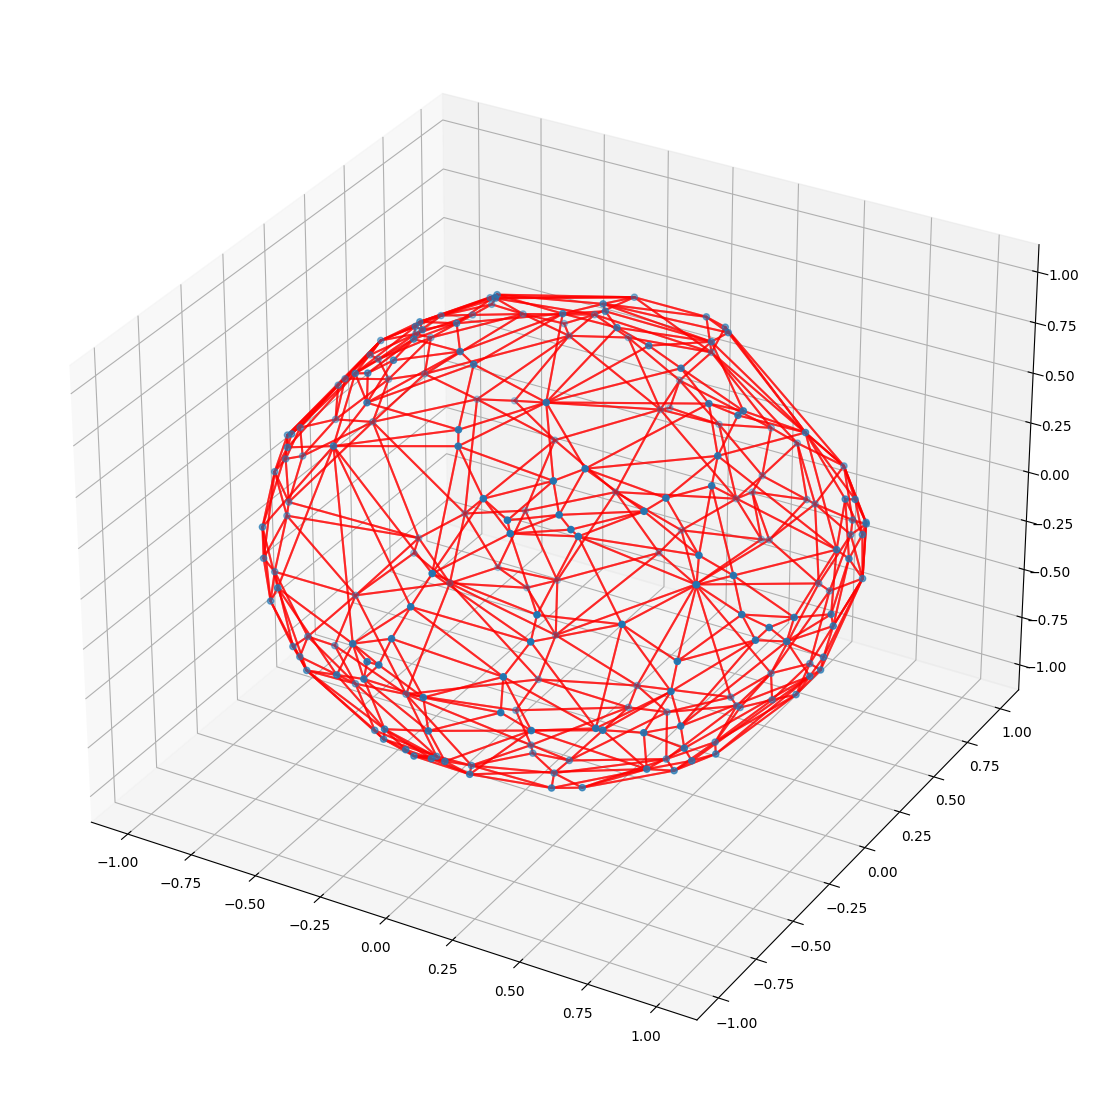

In [22]:
#try to plot the triangles of the Delaunay tesselation to see if they look reasonable by visual inspection relative to the data points:
fig2 = plt.figure()
fig2.set_size_inches(14,14)
ax = fig2.add_subplot(111, projection='3d')
for triangle_coordinate_array in Delaunay_point_array:
    #plot the Delaunay edges in red--using separate calls to close the triangles
    ax.plot(triangle_coordinate_array[...,0],triangle_coordinate_array[...,1],triangle_coordinate_array[...,2],c='r',alpha=0.6)
    connecting_array = np.delete(triangle_coordinate_array,1,0)
    ax.plot(connecting_array[...,0],connecting_array[...,1],connecting_array[...,2],c='r',alpha=0.6)
ax.scatter(cartesian_coord_array[...,0],cartesian_coord_array[...,1],cartesian_coord_array[...,2])
    

In [23]:
import networkx as nx 
import itertools

G = nx.Graph()

all_labels = []
map_d = dict(zip([tuple(c) for c in cartesian_coord_array], range(len(cartesian_coord_array))))

for coords in Delaunay_point_array:
    labels = []
    for coord in coords:
        labels.append(map_d[tuple(coord)])

    G.add_nodes_from(labels)
    edges = list(itertools.combinations(labels, 2))
    G.add_edges_from(edges)
    all_labels.append(labels)

    break
# Verify that matching length
print(len(cartesian_coord_array), len(np.unique(np.hstack(all_labels))))

200 3


In [24]:
import networkx as nx 
import itertools 
import scipy 
from py_sphere import voronoi_utility

def create_network(cartesian_coord_array, attributes, t=1, scale=0.2):   
    # Get 3D spheric delaunay triangulization 
    voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(cartesian_coord_array)
    Delaunay_point_array = voronoi_instance.delaunay_triangulation_spherical_surface()

    # Create network 
    G = nx.Graph()

    all_labels = []
    map_d = dict(zip([tuple(c) for c in cartesian_coord_array], range(len(cartesian_coord_array))))
    for coords in Delaunay_point_array:
        labels = []
        for coord in coords:
            labels.append(map_d[tuple(coord)])

        G.add_nodes_from(labels)
        edges = list(itertools.combinations(labels, 2))
        G.add_edges_from(edges)
        all_labels.append(labels)
    
    # Verify length match between the two
    # assert len(cartesian_coord_array) == len(np.unique(np.hstack(all_labels))
    assert (np.array([map_d[tuple(c)] for c in cartesian_coord_array]) == range(len(cartesian_coord_array))).all()
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(cartesian_coord_array, cartesian_coord_array)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), attributes)), "labels")
    nx.set_node_attributes(g, dict(zip(g.nodes(), cartesian_coord_array)), "pos")
    return g

In [25]:
graph_layout_data.head()

,x,y,z,x_norm,y_norm,z_norm,ACTB,B2M,CD102,CD11a,...,CD8,CD82,CD84,CD86,HLA-ABC,HLA-DR,TCRb,mIgG1,mIgG2a,mIgG2b
ATTGTGAAATTGGATATAGAAATTT,0.221204,-4.762181,7.229898,0.025543,-0.549894,0.834844,0,2,1,1,...,10,0,0,0,11,0,0,0,0,0
TTTTATCGTCAGAGCGTGTTTTAAG,16.150262,-11.127568,-13.743853,0.674365,-0.464639,-0.573884,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCGCGGAGGAGGCTTTTGTATTGTG,23.004560,6.500257,19.092309,0.751936,0.212470,0.624059,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
GTTTTGTATAGAATTTGGGCAGGAA,7.094220,16.871143,8.186504,0.353835,0.841475,0.408315,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ATATGTATACTCCGGAGGCGTACAC,-3.218108,9.081413,17.870021,-0.158513,0.447319,0.880216,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cartesian_coord_array = graph_layout_data[['x_norm', 'y_norm', 'z_norm']].values
attributes = graph_layout_data.iloc[:, 6:].values


In [27]:
G = create_network(cartesian_coord_array, attributes, t=1, scale=0.2)

In [28]:
plt.style.use('dark_background')

def plot_PPI_3D(network):
    # Get position dict
    pos_dict = nx.get_node_attributes(network, 'pos')
    pos_T = {k: v[[1,0,2]] for k,v in pos_dict.items()}
    # Get position array
    pos = np.array(list(pos_T.values()))
    # Get node and edge location
    node_xyz = np.array([pos_T[v] for v in sorted(network)])
    edge_xyz = np.array([(pos_T[u], pos_T[v]) for u, v in network.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection="3d")

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='w', lw=1)
    ax.scatter(*node_xyz.T, s=10, color='red')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    return fig, ax

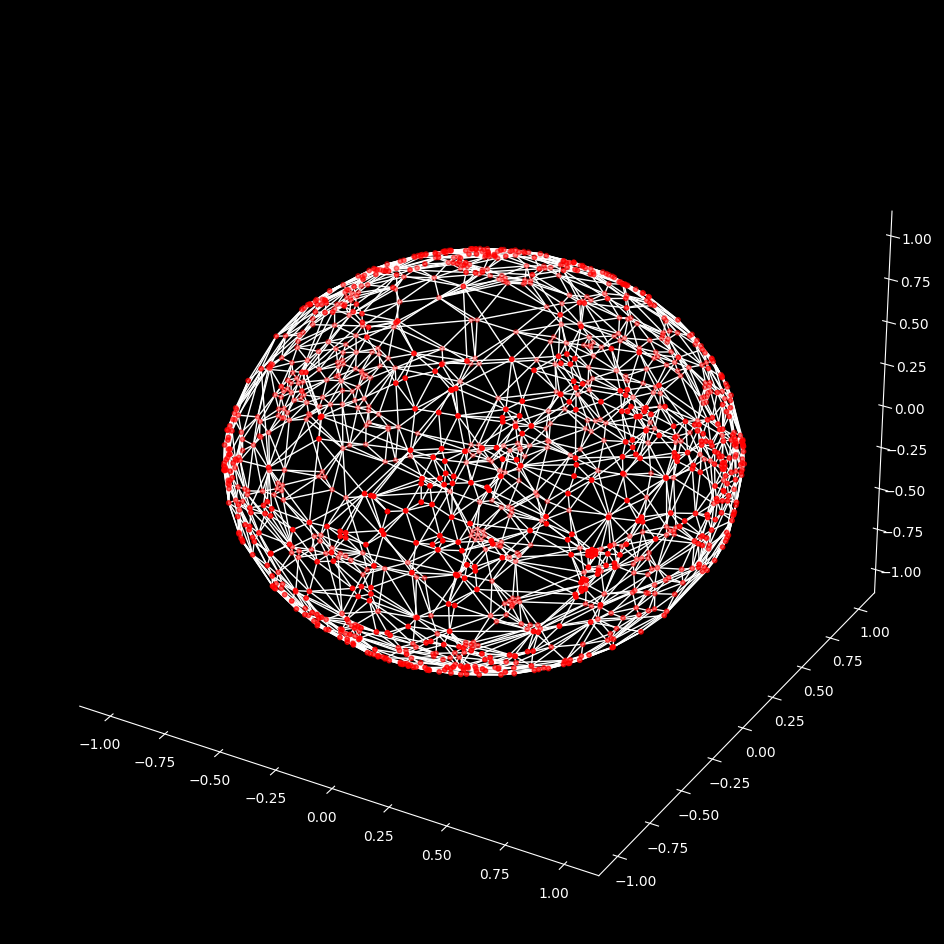

In [29]:
fig, ax = plot_PPI_3D(G)

# Loop through dataset 

In [30]:
from pathlib import Path
from tqdm import tqdm

DATA_DIR = Path.cwd().parents[0] / "data" / 'pixelgen' / 'raw'
data_files = [
    DATA_DIR / "Sample03_Raji_control.dataset.pxl",
    DATA_DIR / "Sample04_Raji_Rituximab_treated.dataset.pxl",
]
# data_files = [
#     DATA_DIR / "Uropod_control.dataset.pxl",
#     DATA_DIR / "Uropod_CD54_fixed_RANTES_stimulated.dataset.pxl",
# ]


In [31]:
pg_data_combined = simple_aggregate(
    ["Control", "Stimulated"], [read(path) for path in data_files]
)

components_to_keep = pg_data_combined.adata[
    (pg_data_combined.adata.obs["edges"] >= 5000)
    & (pg_data_combined.adata.obs["tau_type"] == "normal")
].obs.index

pg_data_combined = pg_data_combined.filter(
    components=components_to_keep
)

polarity_scores = pg_data_combined.polarization
colocalization_scores = pg_data_combined.colocalization
edgelist = pg_data_combined.edgelist

In [32]:
pg_data_combined.adata.obs['sample'].value_counts()
markers = pg_data_combined.adata.var_names.tolist()

In [34]:
pg_data_combined.adata.obs['sample'].value_counts()

Stimulated    813
Control       538
Name: sample, dtype: int64

In [35]:

# for row in tqdm(pg_data_combined.adata.obs.itertuples(), total=len(pg_data_combined.adata.obs)):
#     # Get component name
#     component = row.Index

#     graph = pg_data_combined.graph(component,
#                                 add_node_marker_counts=True,
#                                 simplify=True,
#                                 use_full_bipartite=True)
#     graph_layout_data = graph.layout_coordinates("fruchterman_reingold_3d",
#                                                 only_keep_a_pixels=True,
#                                                 get_node_marker_matrix=True, )
#     attributes = graph_layout_data.iloc[:, 6:].reindex(columns=markers, fill_value=0).values
#     print(attributes.shape)
#     break

In [36]:
import pickle 
from tqdm import tqdm 

data_dir = (Path().cwd().parents[0] / 'data').absolute()

In [37]:
graph_save_path =  data_dir / 'pixelgen' / 'graphs' / 'raw'
graph_save_path .mkdir(parents=True, exist_ok=True)

for row in tqdm(pg_data_combined.adata.obs.itertuples(), total=len(pg_data_combined.adata.obs)):
    # Get component name
    component = row.Index

    graph = pg_data_combined.graph(component,
                                add_node_marker_counts=True,
                                simplify=True,
                                use_full_bipartite=True)
    graph_layout_data = graph.layout_coordinates("fruchterman_reingold_3d",
                                                only_keep_a_pixels=True,
                                                get_node_marker_matrix=True, )
    
    cartesian_coord_array = graph_layout_data[['x_norm', 'y_norm', 'z_norm']].values
    attributes = graph_layout_data.iloc[:, 6:].reindex(columns=markers, fill_value=0).values

    assert attributes.shape[1] == len(markers)

    G = create_network(cartesian_coord_array, attributes, t=1, scale=0.2)


    # Save pgrahs
    save_path = graph_save_path / ('_'.join(component.split('_')[::-1])+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████| 1351/1351 [46:01:30<00:00, 122.64s/it]   
